# Explaining Non-Parametric Additive Models

This tutorial will discuss **Non-Parametric Additive Models** and how they complement the parametric additive models introduced previously. We will see that, again, viewing explainability as a relative concept is useful to get unambiguous interpretations of model decisions. Additionally, we will delve into the topic of
fairness in Machine Learning, and how additive models can help practitionners understand the root cause of the
unfairness in their model.

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from joblib import dump, load

## Additive Models

### Definition
An additive model takes the following form

$$ h(x) = \omega_0 + \sum_{i=1}^d h_i(x_i),$$

where each *shape function* $h_i$ only depends on a single feature $x_i$. By design, the contribution of each 
individual feature toward the prediction $h(x)$ is readily-available, which is why additive models are 
advertised as being transparent. We saw previously that the shape functions could be modeled parametrically using linear model on top of a basis expansion (using splines or step functions). The issue with this approach
is that the basis functions must be chosen apriori so it requires a lot of experimentation to deciding the optimal placement and numbers of spline/steps basis functions.

The alternative is to model the shape functions **Non-Parametrically** (without learning parameters). 
The most successful way to model shape functions is to train Decision Trees iteratively. A decision is 
a function that splits the input space into regions and returns a constant prediction in each region.

<p align="center">
    <img src="./Images/DecisionTrees.png" width="600">
</p>

The idea behing `ExplainableBoostingMachines` (EBMs for short) is to learn those trees on individual features
in a round-robin fashion (fit a tree on $x_1$, fit on $x_2$, ..., fit on $x_d$, fit on $x_1$ etc.). Each
tree is trained to minimize the error made by all previous trees. After a large number of rounds, all trees
involving feature $x_i$ are summed yielding the shape function $h_i(x_i)$.

<p align="center">
    <img src="./Images/EBMs.png" width="600">
</p>

Let's investigate EBMs on the adult income dataset.

## Adult-Income

The Adult-Income dataset aims at predicting whether or not invividuals in the US make more ($y=1$) or less
($y=0$) than 50K USD. The data contains 49K instances taken from the 1994 Census. Although this dataset is
outdated, it is still popular as a baseline for new ideas in the explainability and fairness fields.

In [2]:
from pyfd.data import get_data_adults

X, y, features, gender = get_data_adults(remove_gender=True)
print(X.shape)
print(y[:20])
print(gender[:10])
features.summary()

/home/gabriel/Desktop/POLY/PHD/Research/FunctionalDecomp/PyFD/pyfd/data.py:299: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'income': {'<=50K': 0, '<=50K.': 0,  '>50K': 1, '>50K.': 1}})


(48842, 11)
[0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0]
['Male', 'Female', 'Male', 'Female', 'Male', 'Male', 'Male', 'Male', 'Female', 'Female']
|Idx|        Name        |        Type        |    Card    |      Groups      |
-------------------------------------------------------------------------------
| 0 | age                | num                | inf        | [0]              |
| 1 | educational-num    | num                | inf        | [1]              |
| 2 | capital-gain       | sparse_num         | inf        | [2]              |
| 3 | capital-loss       | sparse_num         | inf        | [3]              |
| 4 | hours-per-week     | num                | inf        | [4]              |
| 5 | workclass          | nominal            | 4          | [5]              |
| 6 | education          | nominal            | 8          | [6]              |
| 7 | marital-status     | nominal            | 5          | [7]              |
| 8 | occupation         | nominal            | 6        

This dataset involves many features that describe the social-demographic and economic status of each individual.
It also contains a `gender` feature, which takes the values `Female` or `Male`. Depending on your application, it
might be prohibited to use this feature for prediction. Thus, I removed it from `X` (by passing `remove_gender=True`) and so the predictive model cannot use it. Still, the `gender` is kept in a separate 
array that will be used later.

In [4]:
X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(X, y, gender,
                                                                               test_size=0.3, 
                                                                               stratify=y, 
                                                                               random_state=42)

### Fitting the model

We fit an EBM using the `ExplainableBoostingClassifier` from the `interpret` Python library. 

In [5]:
from interpret.glassbox import ExplainableBoostingClassifier

model = ExplainableBoostingClassifier(random_state=0, interactions=0, n_jobs=-1)
model

ExplainableBoostingClassifier(interactions=0, n_jobs=-1, random_state=0)

**The cells bellow only need to be run once, since the predictor will be saved locally. If you have already trained the model, skip this part.**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold

grid = {"max_bins": [256, 512, 1024],
        'outer_bags' : [10, 15],
        'learning_rate' : [1, 0.1, 0.01]}
search = RandomizedSearchCV(
    model,
    cv=KFold(),
    scoring='accuracy',
    param_distributions=grid,
    verbose=2,
    n_iter=40
)
search.fit(X_train, y_train)

In [15]:
# Recover the optimal CV model
model = search.best_estimator_
res = search.cv_results_
cv_perf = np.nan_to_num(res['mean_test_score'], nan=-1e10)
best_idx = np.argmax(cv_perf)
print(cv_perf[best_idx])

0.8689639622816905


In [16]:
# Pickle the model
dump(model, os.path.join("models", "adult_ebm.joblib"))

['models/adult_ebm.joblib']

**Start from here if you have already trained the model**

In [6]:
# Load the model
model = load(os.path.join("models", "adult_ebm.joblib"))


The output of the EBM model is $h(x)=\omega_0 + \sum_{i=1}^d h_i(x_i)$, which is a numerical value (for example $-2.53$, or $4.13$). These predictions are accessible with the `.decision_function` method. 


In [7]:
test_outputs = model.decision_function(X_test)
print(test_outputs[:10])

[-2.57411113 -0.55329328 -3.15049385 -2.91860851  1.13860417 -2.29570428
  8.81168776 -6.46397487 -4.5117488  -3.95804441]



However, since we perform classification, our goal is to get binary labels ($\hat{y}=1$ or $\hat{y}=0$). To
get those, EBMs uses the **sign** of $h(x)$. A positive output $h(x)>0$ means that the label is predicted to be $1$, while a negative output $h(x)<0$ implies that a $0$ label is returned. These discrete predictions are
accessible via the `.predict` methods.


In [8]:
predict_via_outputs = (test_outputs > 0).astype(np.int64)
test_predict = model.predict(X_test)
assert (predict_via_outputs == test_predict).all()

Discrete predictions are used to estimate the model accuracy, but next section will explain the numerical output.

In [9]:
# The accuracy on the test set
print(np.mean(y_test == test_predict))

0.8704019654678223


### Naively Explaining the model

We saw that explaining Linear Models and Parametric Addive Models required viewing explainability as a relative
concept. The same holds for the Non-Parametric Additive Model that we just fitted. Indeed, we could frame the
local importance of $x_i$ toward a prediction $h(x)$ as

$$\text{Local Importance of } x_i = h_i(x_i).$$

However, this formulation has a key problem : the non-parametric shape functions $h_i$ could be modified
by adding a constant $C$ to all leaves of the decision trees involving $x_i$. This vertical shift in $h_i$
could be cancelled out by adjusting the intercept $\omega_0$ accordingly

$$h(x) = \omega_0 + h_1(x_1) + h_2(x_2) = \omega_0 - C + (h_1(x_1) + C) + h_2(x_2) = \omega_0' + h'_1(x_1) + h_2(x_2).$$

Although the prediction is kept intact, the local importance of $x_i$ can vary arbitrarily.

### Correctly Explaining the model
Instead of explaining the prediction $h(x)$, we should explain the Gap between the prediction and a background
distribution $\mathcal{B}$.

$$G(h, x, \mathcal{B}) = h(x) - \mathbb{E}_{z\sim\mathcal{B}}[h(z)].$$

`PyFD` advocates reporting the local importance of a feature as follows

$$\text{Local Importance of } x_i = h_i(x_i) - \mathbb{E}_{z\sim\mathcal{B}}[h_i(z_i)].$$

These local importance scores satisfy the crucial property of summing up to the Gap

$$\sum_{i=1}^d \text{Local Importance of } x_i = G(h, x, \mathcal{B})$$

so they can be seen as *explaining* the Gap. Moreover, these quantities are invariant to the choice of 
constant $C$ that we add to the shape functions. `PyFD` provides built-in functions to compute the local
feature importance of an EBM model.

In [10]:
from pyfd.decompositions import get_components_ebm

# The reference data
background = X
# We want to explain the predictions at each test instance
foreground = X_test
# Under the hood, PyFD computes : Imp x_i = h_i(x_i) - E_{z~B}[h_i(z_i)] 
decomp = get_components_ebm(model, foreground, background, features, anchored=False)
print(decomp.keys())
print(decomp[(0,)].shape)

dict_keys([(), (0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,)])
(14653,)


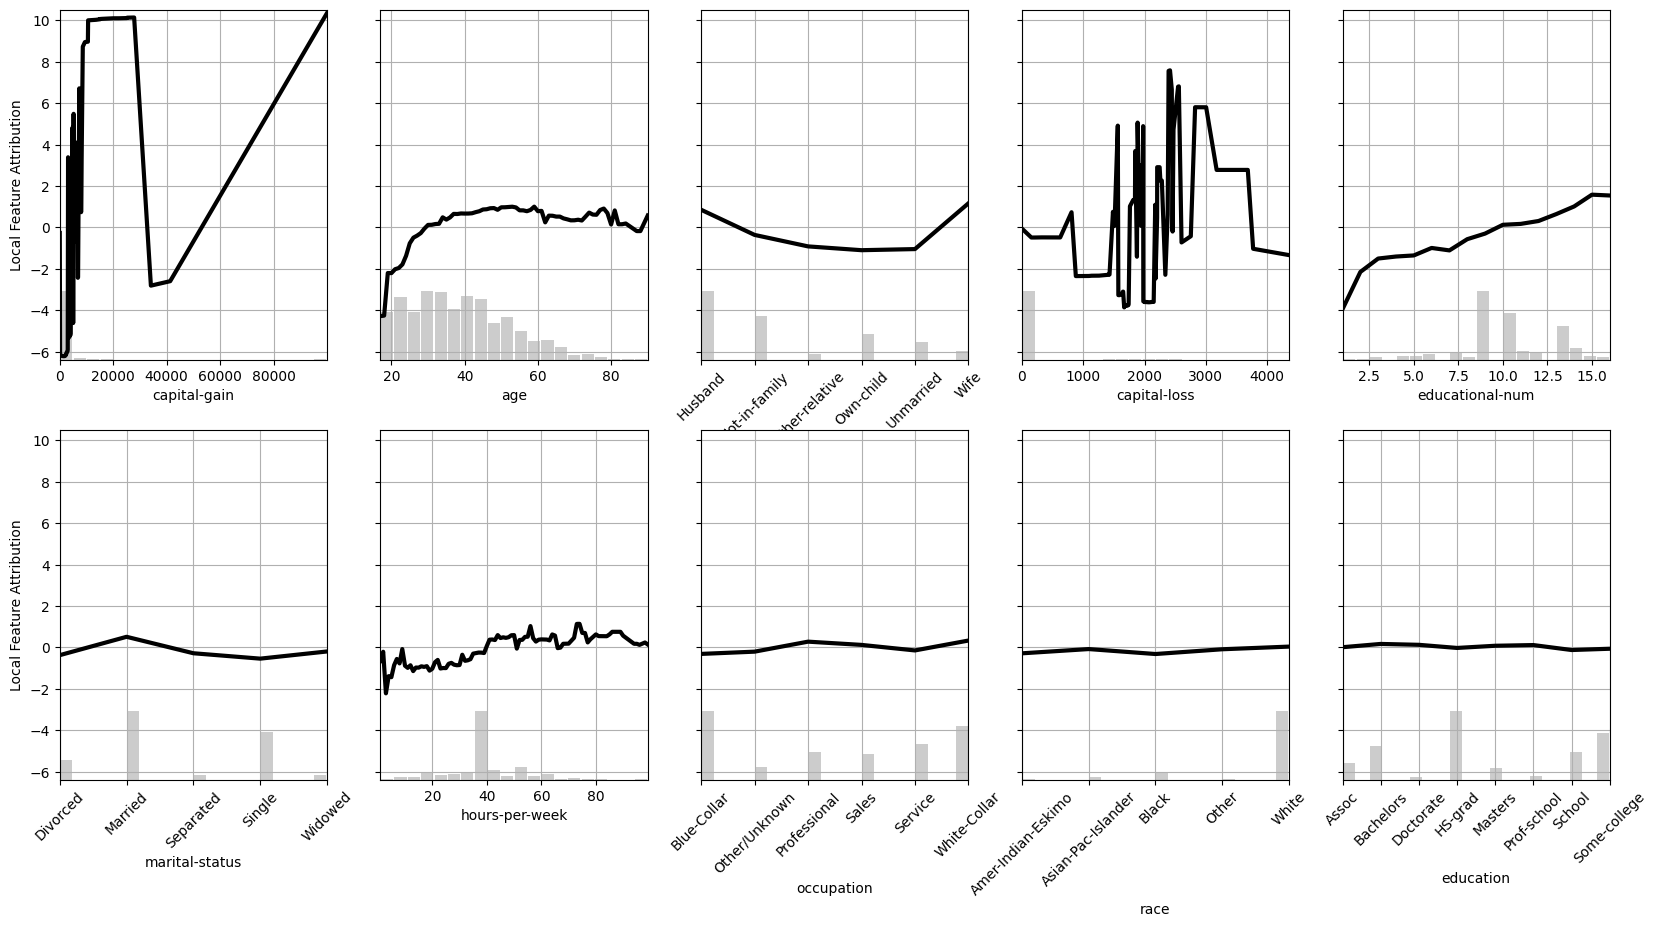

In [11]:
from pyfd.plots import partial_dependence_plot

# Plot the local importance as a function of x_i 
partial_dependence_plot(decomp, foreground, features, plot_hist=True, n_cols=5, idxs=10, figsize=(20, 10))

You can see how individual features impact the model response. There are some notable trends worth pointing out.
- The likelihood of making more than 50K in 1996 increases with `age` and `educational-num`.
- According to the `relationship` feature, people who are married (`relationship` is `Husband` of `Wife`) are more likely to make more than 50K than the rest of the population.
- Higher capital gains are associated with higher likelihood of having $y=1$. However, there is a weird drop at
around 40K.

Speaking of the weird drop in the capital gain feature, we can compute a more detailed graph by passing
a `np.linspace` as the foreground.

In [12]:
import matplotlib.pyplot as plt

feature_idx = 2
foreground = np.linspace(0, X[:, feature_idx].max(), 800)
one_component = get_components_ebm(model, foreground, background, features=features.select([feature_idx]), anchored=False)

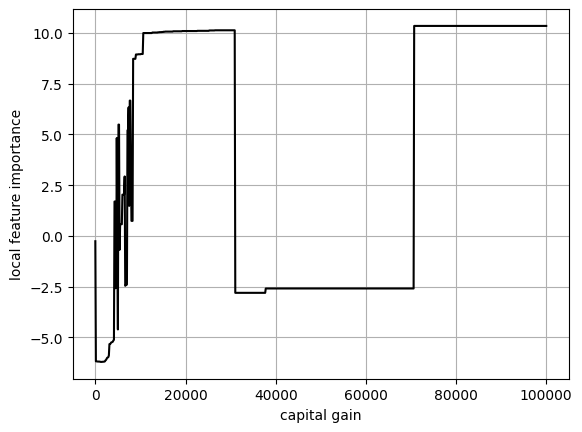

In [13]:
plt.figure()
plt.plot(foreground, one_component[(0,)], 'k-')
plt.xlabel("capital gain")
plt.ylabel("local feature importance")
plt.grid("on")

We can see that the drop in local importance occurs in the 30K-70K range. I suspect that this is due to noise
in the data : perhaps some individual within this range had typos in their target. Or maybe there is an unknown confounding variable that explains this drop. Either way, we cannot know for sure since this dataset is so old.

One of the advantages of EBMs is that their shape functions can be corrected to better fit with the prior knowledge about a task.
Here, we could enforce a monotonous relationship between capital gain and income.

0.863167951955231


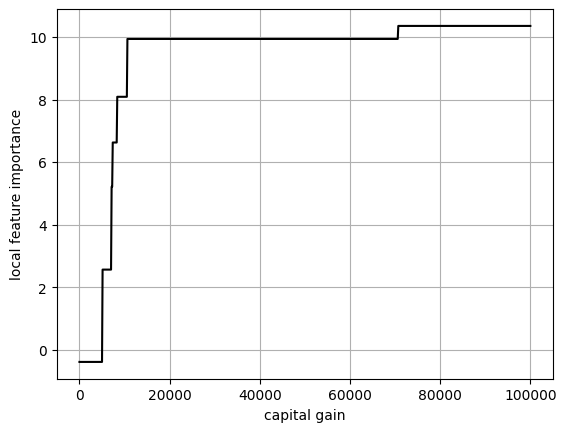

In [14]:
# This will modify the model in-place.
model.monotonize(feature_idx)
# The test-accuracy will be reduced by about 1%
print(model.score(X_test, y_test))
# But the local importance of Capital Gain will better match with prior knowledge
one_component = get_components_ebm(model, foreground, background, features=features.select([feature_idx]), anchored=False)

plt.figure()
plt.plot(foreground, one_component[(0,)], 'k-')
plt.xlabel("capital gain")
plt.ylabel("local feature importance")
plt.grid("on")

Finally, we compute the global feature importance via 

$$ \Phi_i(h) = \sqrt{\mathbb{E}_{x\sim \mathcal{B}}[(\text{Local Importance of } x_i)^2]}.$$

An important characteristic of `PyFD` is that global feature importance is computed by **aggregating**
local feature importance across the data. This aggregation is left to the user.

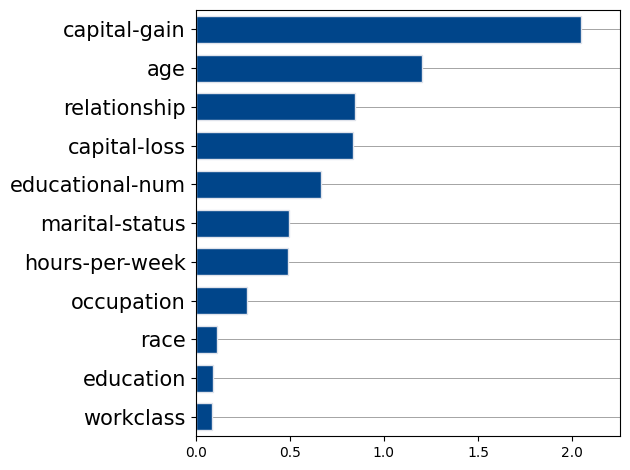

In [15]:
from pyfd.plots import bar

GFI = np.stack([(decomp[(i,)]**2).mean() for i in range(len(features))])
GFI = np.sqrt(GFI)
features_names = features.names()
bar(GFI, features_names)

### Explaining the Unfairness

Fairness is growing topic in Machine Learning because, although models hold the promise of providing
objective opinions based on empirical data, their strong reliance on historical data means that they can
perpetuate past injustices/discrimination. In the case of the Adult-Income dataset, in 1994 there was an 
imbalance in the incomes between men and women, which is inherited by the learned model. We can
report the Gap

$$ \mathbb{E}[h(x)| \text{man}] - \mathbb{E}[h(x)|\text{woman}]$$

to see a difference favoring men.

In [16]:
test_women = X_test[np.array(gender_test)=="Female"] 
test_men = X_test[np.array(gender_test)=="Male"] 
Gap = model.decision_function(test_men).mean() - model.decision_function(test_women).mean()
print(Gap)

1.9110001046647007


On average, men have a likelihood score that is higher than women by almost 2. What are the causes
of this disparity? Remember that the `gender` feature is not accessible by the model. As a result, this is
a case os **indirect** discrimination, which can be legal depending on which factors (or proxies) are inducing
the disparity. 

Think for instance of firefighting departements. Their gender imbalance can be explained by
the strong physical requirements and correlations between strength and sex due to biological nature. 
Thus, as long as a firefighting departemement is solely relying in strength criteria to select employees, 
it is unlikely to be sued for gender discrimination.

The same applies for our predictive model. We would like the factors inducing a difference between men and women to be **meritocratic** and not arbitrary. `PyFD` reports the following importance of $x_i$ toward the men-women
disparity

$$\text{Fairness importance of } x_i = \mathbb{E}[h_i(x_i)|\text{man}] - \mathbb{E}[h_i(x_i)|\text{woman}] $$

These importance scores sum to the Gap between men and women.

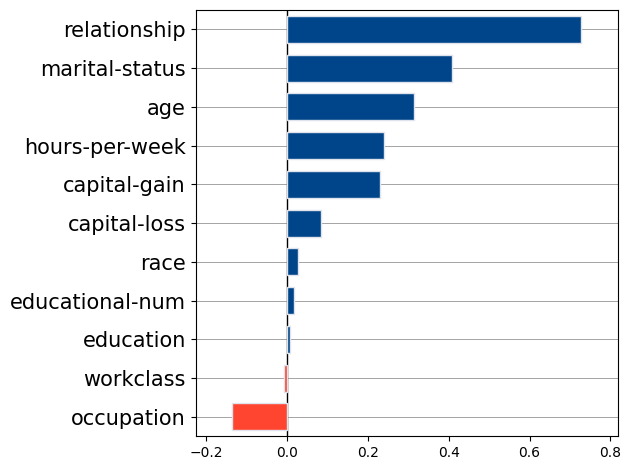

In [17]:
decomp_women = get_components_ebm(model, test_women, background, features, anchored=False)
decomp_men = get_components_ebm(model, test_men, background, features, anchored=False)
fairness_importance = np.stack([decomp_men[(i,)].mean() - decomp_women[(i,)].mean() for i in range(len(features))])
bar(fairness_importance, features.names())

The main factors favoring men are `relationship`, `marital-status`, `age`, `capital-gain`, and `hours-per-week`. We can visualize how the features `relationship` and `marital-status` induce a disparity.

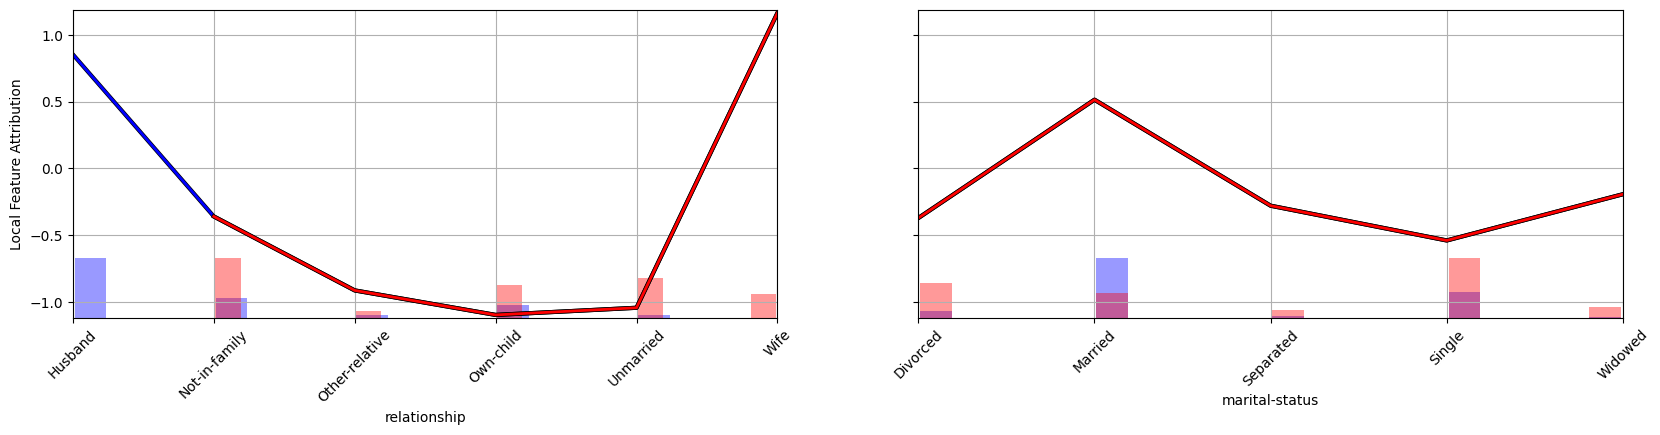

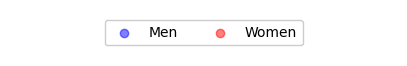

In [20]:
from pyfd.plots import plot_legend

partial_dependence_plot([decomp_men, decomp_women], [test_men, test_women], features, plot_hist=True, 
                        idxs=[7, 9], figsize=(20, 4), n_cols=5)
plot_legend(["Men", "Women"])

In blue we see the distribution of men while in red we see the one for women. The importance of $x_i$ toward the
men/women Gap is the difference in average of $h_i$ between the blue and red distributions. These plots reveal
that a larger proportion of women (compared to men) are not married. Since being married increases the model
numerical output, men have (on average) a higher score than women. 

To resume, when an EBM model is used, `PyFD` allows one to understand how individual features affect the model predictions locally, globally, and between demographic subgroups.